# Simulation of EGF stimulation in drug-adapted BRAF<sup>V600E</sup> melanoma cells using the MARM1 model

Here you can simulate the time-course respose of drug-adapted BRAF<sup>V600E</sup> melanoma cells to addition of exogenous EGF. This code simulates the time-course response of A375 melanoma cells adapted to a dose of RAF (vemurafenib) and/or MEK inhibitors (cobimetinib) and then stimulated with EGF.

**Note**: this code performs the simulation for a single condition and visualizes the time-course response. Use the Jupyter Notebook *MARM1_simulation_multiple_conditions.ipynb* to generate simulation results for multiple conditions (e.g. multiple dose combinations). 



## Import of libraries
Importing libraries necessary to run MARM1 model simulations.

In [49]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Importing the MARM1 PySB model and the simulator.  

In [50]:
from pysb.simulator import ScipyOdeSimulator
from pysb.core import as_complex_pattern

from MARM1 import model

## User-defined experimental setup
In this section you can alter the setup of the experiment simulated by MARM1. First, you need to define the experimental setup of the pre-treatment phase and of the subsequent ligand stimulation phase. The variables needed for the pre-treatment phase are:

<b>RAFi_concentration ($\mu$M)</b>: defines the concentration of the RAF inhibitor (vemurafenib) during the pre-treatment and treatment phase. 

<b>MEKi_concentration ($\mu$M)</b>: defines the concentration of the RAF inhibitor (vemurafenib) during the pre-treatment and treatment phase. 

<b>EGFR_expression (fold-change from basal)</b>: defines the level of expression of the EGFR protein. A value of 1.0 represents the baseline expression in A375 cells as determined by absolute proteomics. Values > 1 and <1 denote overexpression and downregulation, respectively. We used a value of 10 and a value of 0.001 to simulate CRISPRa and CRISPRi control of EGFR expression. 

<b>Pretreatment_time (h)</b>: defines the duration of the pre-treatment phase.
    
For the treatment phase, you need to set the concentration of the EGF ligand and the running time of simulation after ligand stimulation. This is done with the following variables:

<b>EGF_concentration (ng/mL)</b>: defines the EGF concentrations used to stimulate cells. We have calibrated the model only using data from 100 ng/mL, which is thus the default value.

<b>Simulation_time (h)</b>: define the simulation time after ligand stimulation. For the stimulation of cells expressing normal levels of EGFR, 2 hours is enough to visualize the pulsatile reactivation of MAPK signaling.

<b>N_time_points</b>: define the number of time points returned by each model simulation. 

Choose the experiment to simulate by setting the following variables and re-running the notebook:

1. **RAF inhibitor** pre-treatment concentration in μM.

In [51]:
RAFi_concentration = 1.0

2. **MEK inhibitor** pre-treatment concentration in μM.

In [52]:
MEKi_concentration = 0.0

X. **EGFR** under- or over-expression. 1.0 represents copy number in unmodified A375 cells, < 1 denotes downregulation, and > 1 denotes overexpression.

In [53]:
EGFR_expression = 1.0

3. **Pretreatment duration** in hours.

In [54]:
t_pretrt = 24

4. **EGF** treatment concentration in ng/mL.

In [55]:
EGF_concentration = 100

5. **Simulation time** in hours.

In [56]:
t_trt = 2

6. **Parameter set** selects which of the 100 best-fit parameter sets to use for the simulation. Set 0 is the best fit and 99 the worst.

In [57]:
param_set_index = 11

7. **N_time_points** defineds the number of time points returned by each individual model simulation

In [58]:
N_time_points = 1000

## Parameter set preparation

Read in the CSV file containing the best-fit parameter sets, and drop the chi$^2$ value which we don't need here.

In [59]:
param_sets = pd.read_csv('parameter_sets.csv', index_col=0)
param_sets = param_sets.drop('chi2', axis=1)

Extract the chosen parameter set and convert it into a dict.

In [60]:
params = param_sets.iloc[param_set_index].to_dict()

Override the `EGFR_crispr` parameter with the user-specified value for EGFR under/over-expression.

In [61]:
params['EGFR_crispr'] = EGFR_expression

## Simulations

First we define some utility functions that will be used below.
*Equilibrate* runs a model simulation till steady state for that parameter set.
*Get_species_index* find and retunrs the index of speies in the model given input specie patterns. 

In [62]:
def equilibrate(simulator, initials):
    """Simulate a model from given initial conditions until it reaches steady state"""
    scale = 10
    t_start = 1e-4
    df = None
    tspan = np.geomspace(t_start, t_start * scale)
    while True:
        print(f"    at t={tspan[-1]:<5.3g} ... ", end='', flush=True)
        res = simulator.run(tspan=tspan, initials=initials)
        df = pd.concat([df, res.dataframe.iloc[1:]])
        initials = res.species[-1]
        close = np.isclose(
            *res.species[[-1,-2]].view(float).reshape(2,-1),
            rtol=1e-3
        )
        cs = np.sum(close)
        n = len(simulator.model.species)
        print(f"{cs}/{n} species converged")
        if np.all(close):
            break
        tspan *= scale
    return df

In [63]:
def get_species_index(model, pattern):
    """Return the integer species number for a given species in the model"""
    pattern = as_complex_pattern(pattern)
    matches = [
        i for i, s in enumerate(model.species)
        if s.is_equivalent_to(pattern)
    ]
    n = len(matches)
    assert n == 1, f"Expected exactly one match, got {n}"
    return matches[0]

## Initial equilibrium
First we run the model from its baseline initial conditions until equilibrium is reached. For example protein synthesis/degradation, phosphorylation/dephosphorylation, and drug binding/unbinding all need to reach steady state to match the state of the cells in the experimental setup. There may be some time without visible progress as behind the scenes PySB runs BioNetGen to generate the reaction network and Cython to compile the resulting differential equations into efficient executable code.

In [64]:
sim = ScipyOdeSimulator(model, param_values=params, atol=1E-50)
df_eq = equilibrate(sim, None)

    at t=0.001 ... 979/1007 species converged
    at t=0.01  ... 982/1007 species converged
    at t=0.1   ... 982/1007 species converged
    at t=1     ... 985/1007 species converged
    at t=10    ... 993/1007 species converged
    at t=100   ... 1007/1007 species converged


Now that the model has been simulated once and the actual molecular species have been enumerated, we can find the exact species numbers for the inhibitors and EGF. These are needed so that their concentrations can be overridden in the model state for subsequent simulations.

In [65]:
RAFi_index = get_species_index(model, model.monomers.RAFi(raf=None))
MEKi_index = get_species_index(model, model.monomers.MEKi(mek=None))
EGF_index = get_species_index(model, model.monomers.EGF(rtk=None))

## Inhibitor pre-treatment

We take the final state of the equilibration simulation and use it as the initial state of this new simulation, overriding the RAFi and MEKi concentrations with the user-selected values.

In [66]:
initials_pre = df_eq.iloc[-1, :len(model.species)].copy()
initials_pre[RAFi_index] = RAFi_concentration
initials_pre[MEKi_index] = MEKi_concentration
initials_pre[EGF_index] = 0.0

#fixed time pre-treatment 
tspan_pretrt = np.linspace(0, t_pretrt, N_time_points)
pre_sim= sim.run(tspan=tspan_pretrt, initials=initials_pre)
df_pre_sim = pre_sim.dataframe

#run to steady state pre-tretment
#df_pre_sim = equilibrate(sim, initials_pre)

We want to retain only the first 24 hours of pre-treatment plus the state at final equilibrium, so we cut the time series down using a Pandas slice operation and adjust the remaining time values to begin at -24.

In [67]:
pre_time_max = t_pretrt
df_pre = pd.concat([df_pre_sim.loc[:pre_time_max], df_pre_sim.iloc[[-1]]])
df_pre['time'] = df_pre.index
df_pre['time'] -= df_pre['time'].iloc[-2]
df_pre['time'].iloc[-1] = 0
df_pre = df_pre.set_index('time')

## EGF treatment

We run another simulation starting from the final state of the pre-treatment simulation, overriding the EGF concentration with the user-selected value. This is a fixed-time simulation rather than the steady-state equilibration used in the previous simulations.

In [68]:
tspan_trt = np.linspace(0, t_trt, N_time_points)
initials_trt = df_pre.iloc[-1, :len(model.species)].copy()
initials_trt[EGF_index] = EGF_concentration
res_trt = sim.run(tspan=tspan_trt, initials=initials_trt)

Concatenate the dataframes holding the pre-treatment and treatment simulation trajectories, keeping only the columns corresponding to model observables. Also filter out "noise" (insignificant concentration fluctuations caused by numerical integration tolerance issues).

In [69]:
obs_names = [x.name for x in model.observables]
obs = pd.concat([df_pre, res_trt.dataframe])[obs_names]
obs.loc[:, (obs < 1e-10).all()] = 0

## Write time courses to CSV file

Append information on parameter sets used in this simulation and save the time course trajectories to file.

In [70]:
df_settings=pd.DataFrame(obs.shape[0]*[[param_set_index, t_pretrt, RAFi_concentration, MEKi_concentration, t_trt, EGF_concentration, EGFR_expression]], columns=['param_set_index', 'time_pre_treatment' , 'RAFi_concentration' , 'MEKi_concentration' , 'time_treatment', 'EGF_concentration', 'EGFR_expression'] )
obs = obs.join(df_settings.set_index(obs.index))
obs.to_csv('trajectories_single_run.csv')

## Plot time courses

Plot time-course trajectories of meaninfgul model species. The pre-treatment timescale is collapsed on a smallar interval for display purposes.

In [71]:
pre_time_scale = 0.5
obs_plot = obs.reset_index()
time_scale_factor = pre_time_scale / -obs_plot['time'].iloc[0]
obs_plot.loc[obs_plot['time'] < 0, 'time'] *= time_scale_factor

<IPython.core.display.Javascript object>


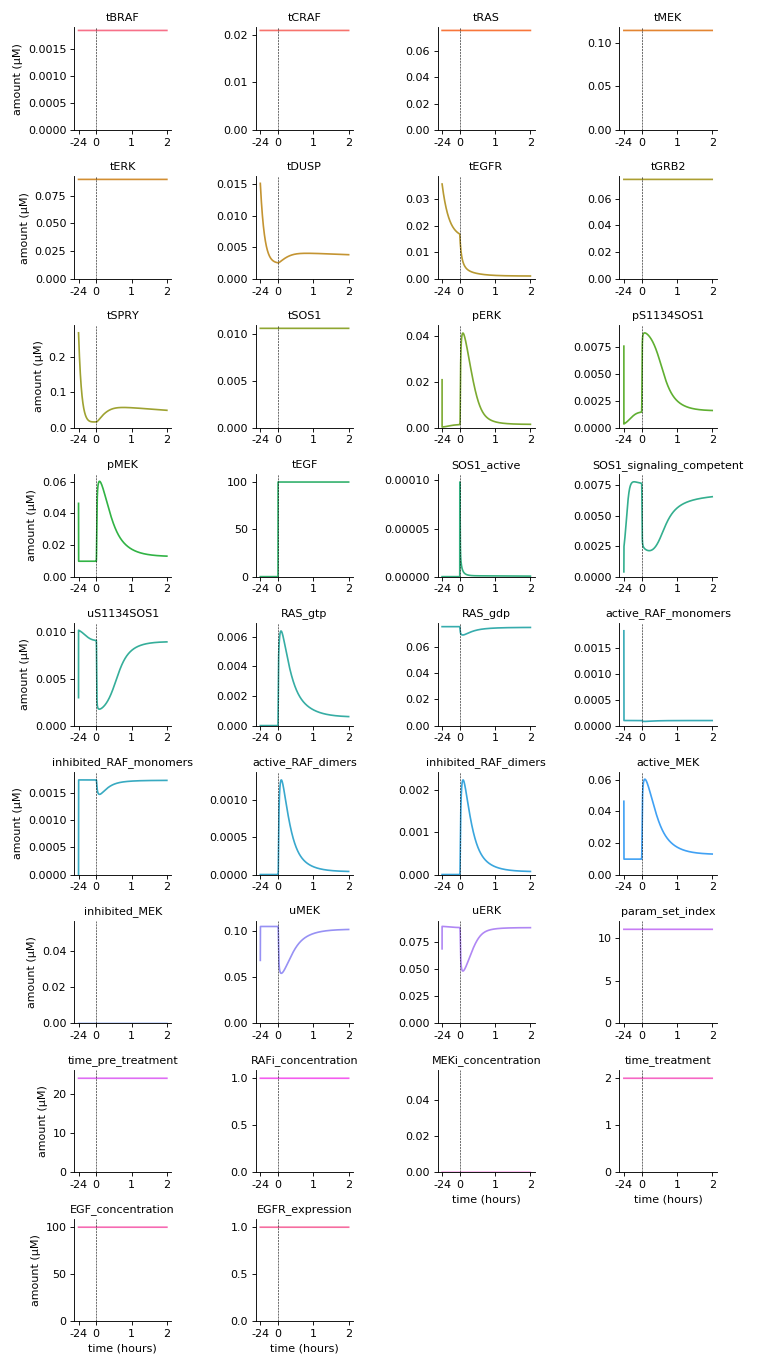

In [72]:
obs_melted = obs_plot.melt(id_vars='time')
g = sns.FacetGrid(
    obs_melted, col='variable', hue='variable', col_wrap=4,
    sharex=False, sharey=False, size=1.9, aspect=1.25
)
g.map(plt.plot, 'time', 'value')
for ax in g.axes:
    _, ymax = ax.get_ylim()
    ax.set_ylim(ymin=0, ymax=ymax * 1.03)
    ax.set_xticks([-pre_time_scale, 0, 1, t_trt])
    ax.set_xticklabels(['-'+str(t_pretrt), '0', '1', str(t_trt)])
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
g.set_titles('{col_name}')
g.set_xlabels('time (hours)')
g.set_ylabels('amount (\u03bcM)')
plt.tight_layout()